In [1]:
from numba import cuda

# Liberar memoria de GPU en TensorFlow
tf.keras.backend.clear_session()

# Reiniciar GPU con numba
cuda.select_device(0) # 0 es el índice de la GPU
cuda.close()
cuda.select_device(0)

ModuleNotFoundError: No module named 'numba'

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, BackupAndRestore

from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dense, Reshape, Concatenate, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import model_to_dot, plot_model
from IPython.display import SVG
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import matthews_corrcoef

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.applications import InceptionResNetV2
from sklearn.model_selection import cross_val_score, KFold
from tensorflow.keras.layers import Layer

from skimage.transform import resize

def plot_combined_history(history, columns=2):
    # Verifica si el historial es un objeto 'History' de Keras
    if hasattr(history, 'history'):
        history = history.history
    
    metrics = [key for key in history.keys() if not key.startswith('val_')]
    num_metrics = len(metrics)
    rows = (num_metrics + columns - 1) // columns  # Calcula el número de filas necesarias

    plt.figure(figsize=(15, 5 * rows))
    
    for i, metric in enumerate(metrics):
        plt.subplot(rows, columns, i + 1)
        plt.plot(history[metric], label=f'Training {metric}')
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Generador de datos

In [2]:
class MedicalImageDataGenerator(Sequence):
    def __init__(self, data_dir, indices=None, batch_size=32, shuffle=True):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.labels = {'Actionable': 0, 'Benign': 1, 'Cancer': 2, 'Normal': 3}
        self.classes = list(self.labels.keys())
        self.load_data()
        self.on_epoch_end()

    def load_data(self):
        self.data = []
        self.filepaths = []
        self.file_labels = []
        for label in self.classes:
            label_dir = os.path.join(self.data_dir, label)
            filenames = os.listdir(label_dir)
            for filename in filenames:
                filepath = os.path.join(label_dir, filename)
                self.data.append((filepath, self.labels[label]))
                self.filepaths.append(filepath)
                self.file_labels.append(self.labels[label])
        self.indexes = np.arange(len(self.data))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def __getitem__(self, index):
        batch_indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_filepaths = [self.filepaths[i] for i in batch_indices]
        batch_labels = [self.file_labels[i] for i in batch_indices]

        batch_images = []
        for filepath in batch_filepaths:
            array = np.load(filepath)
            batch_images.append(array)

        # Convertir etiquetas a formato one-hot
        batch_labels = to_categorical(batch_labels, num_classes=len(self.classes))
        
        return np.array(batch_images), batch_labels

In [11]:
def convert_to_one_hot(generator, num_classes):
    while True:
        for batch_images, batch_labels in generator:
            batch_labels_one_hot = tf.keras.utils.to_categorical(batch_labels, num_classes=num_classes)
            yield batch_images, batch_labels_one_hot

train_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Sin DA/Division Sin DA/Validacion_Cruzada/Training'
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Sin DA/Division Sin DA/Validacion_Cruzada/Test'

batch_size = 12
n_classes = 4
k = 5

# Total number of files in training data directory
total_files = sum(len(os.listdir(os.path.join(train_data_dir, label))) for label in ['Actionable', 'Benign', 'Cancer', 'Normal'])
all_indices = np.arange(total_files)

print(f"Train indices length: {len(train_indices)}, Validation indices length: {len(val_indices)}")

train_generator = MedicalImageDataGenerator(train_data_dir, batch_size=batch_size)
train_generator_one_hot = convert_to_one_hot(train_generator, n_classes)

# Verificar los datos de entrenamiento
train_generator.verify_data()

print("Verificación completa. No se encontraron errores.")

Train indices length: 2748, Validation indices length: 687
Verificación completa. No se encontraron errores.


In [ ]:
train_data_dir = f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Test Todas Normales'
train_generator = MedicalImageDataGenerator(train_data_dir)

unique_shapes = set()
for data in train_generator:
    unique_shapes.add(np.array(data[0]).shape)

for shape in unique_shapes:
    print(shape)

In [24]:
directory = f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Fold_{1}/Training'

def get_unique_shapes(directory):
    unique_shapes = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.npy'):
                filepath = os.path.join(root, file)
                array = np.load(filepath)
                unique_shapes.add(array.shape)

    return unique_shapes

unique_shapes = get_unique_shapes(directory)
for shape in unique_shapes:
    print(shape)

(4, 299, 299, 3)


Shape de images_batch: (2, 4, 299, 299, 3)


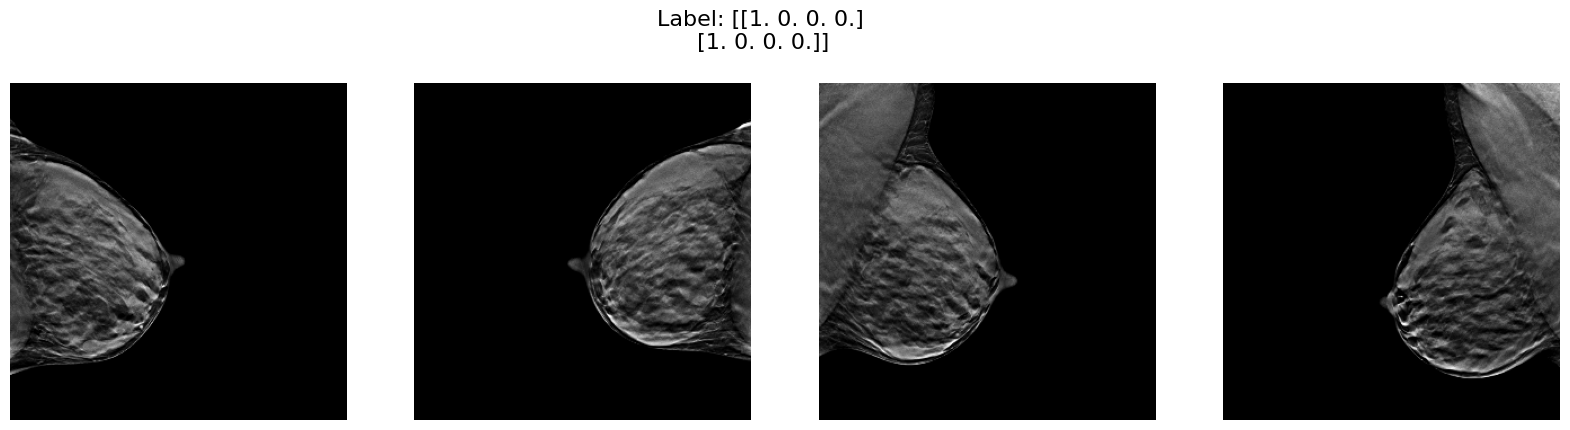

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [4]:
directory = f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Fold_{1}/Training'
batch_size = 12

data_gen = MedicalImageDataGenerator(directory,indices=None, batch_size=2, shuffle=False)

images_batch, labels_batch = data_gen[30]
# Imprimir la forma de los arrays
print(f'Shape de images_batch: {np.array(images_batch).shape}')
#print(f'Shape de labels_batch: {labels_batch.shape}')
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(f'Label: {labels_batch}', fontsize=16)
for i in range(4):
    axes[i].imshow(images_batch[0][i].squeeze())
    axes[i].axis('off')
plt.show()
print(labels_batch)

# Construcción del modelo

In [5]:
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        cross_entropy = categorical_crossentropy(y_true, y_pred)
        weights_tensor = tf.reduce_sum(weights * y_true, axis=-1)
        weighted_loss = cross_entropy * weights_tensor
        return tf.reduce_mean(weighted_loss)
    return loss

def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

# Registering Mish and Temperature Softmax as activation functions
tf.keras.utils.get_custom_objects().update({'mish': tf.keras.layers.Activation(mish)})

def add_prefix_to_layers(model, prefix):
    for layer in model.layers:
        layer._name = prefix + layer.name
def build_inception_model(input_shape=(4, 720, 720, 1), n_classes=4):
    main_input = Input(shape=input_shape)

    # Función Lambda para separar el array principal en cuatro subarrays
    input1 = Lambda(lambda x: x[:, 0, :, :])(main_input)
    input2 = Lambda(lambda x: x[:, 1, :, :])(main_input)
    input3 = Lambda(lambda x: x[:, 2, :, :])(main_input)
    input4 = Lambda(lambda x: x[:, 3, :, :])(main_input)
    
    # InceptionResNetV2 models
    base_model1 = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input1)
    base_model2 = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input2)
    base_model3 = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input3)
    base_model4 = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input4)
    
    # Add prefixes to layer names
    add_prefix_to_layers(base_model1, 'inception1_')
    add_prefix_to_layers(base_model2, 'inception2_')
    add_prefix_to_layers(base_model3, 'inception3_')
    add_prefix_to_layers(base_model4, 'inception4_')

    # Freeze the layers of the base models
    for layer in base_model1.layers:
        layer.trainable = False
    for layer in base_model2.layers:
        layer.trainable = False
    for layer in base_model3.layers:
        layer.trainable = False
    for layer in base_model4.layers:
        layer.trainable = False
    
    #  Capas Global average pooling por cada InceptionV3
    x1 = GlobalAveragePooling2D(name='gap1')(base_model1.output)
    x2 = GlobalAveragePooling2D(name='gap2')(base_model2.output)
    x3 = GlobalAveragePooling2D(name='gap3')(base_model3.output)
    x4 = GlobalAveragePooling2D(name='gap4')(base_model4.output)
    
    concat = tf.keras.layers.Concatenate(name='concat')([x1, x2, x3, x4])
    # print(concat.shape)
    
    # Construir la imagen 2D 96 x 64 x 1 = 6 144
    reshaped = tf.keras.layers.Reshape((96, 64, 1), name='reshaped')(concat)
    
    # print(reshaped.shape)
    
    # Convolutional layer
    conv = Conv2D(32, (2, 2), activation='relu', name='conv')(reshaped)
    
    # Flatten the convolutional output
    flattened = Flatten(name='flatten')(conv)
    
    # Fully connected layer with Mish activation
    fc = Dense(256)(flattened)
    fc = tf.keras.layers.Activation(mish)(fc)
    
    
    output = Dense(n_classes)(fc)
    output = tf.keras.layers.Activation('softmax')(output)
    
    # Create model
    model = Model(inputs=main_input, outputs=output)
    
    return model

# Definir el modelo con una temperatura específica
input_shape = (4, 299, 299, 3)
n_classes = 4
model = build_inception_model(input_shape=input_shape, n_classes=n_classes)

# Compilar el modelo con Adam y weighted_categorical_crossentropy
optimizer = Adam(learning_rate=0.001)
peso_primera_etiqueta = 0
frecuencias_restantes = [777, 896, 1672] # Con DA
#frecuencias_restantes = [388, 896, 1284] # Sin DA
pesos_inversos = [peso_primera_etiqueta] + [1.0 / f for f in frecuencias_restantes]# Calcular la inversa de las frecuencias, asignando peso 0 a la primera etiqueta
suma_pesos_inversos = sum(pesos_inversos)
pesos_normalizados = [p / suma_pesos_inversos for p in pesos_inversos]# Normalizar los pesos
print(pesos_normalizados)
loss = weighted_categorical_crossentropy(pesos_normalizados)

precision = Precision()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', precision])

#model.summary()# Imprimir el resumen del modelo

# Guardar una representación gráfica del modelo en un archivo
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print("La representación gráfica del modelo se ha guardado en 'model_plot.png'.")


[0.0, 0.4288347787057371, 0.3718801596588814, 0.1992850616353814]
La representación gráfica del modelo se ha guardado en 'model_plot.png'.


In [11]:
print(np.array(pesos_normalizados).shape)
print(pesos_normalizados)

(4,)
[0.0, 0.5762969968501791, 0.24955718167172936, 0.17414582147809152]


# Validacion cruzada

In [4]:
for fold in range(1, 6):
    print(f"Training fold {fold}/5")
    train_data_dir = f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Fold_{fold}/Training'
    val_data_dir = f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Fold_{fold}/Validation'

    train_generator = MedicalImageDataGenerator(train_data_dir, indices=None, batch_size=10)
    val_generator = MedicalImageDataGenerator(train_data_dir, indices=None, batch_size=10, shuffle=False)


    checkpoint_filepath = f'Validación cruzada/best_model{fold}.keras'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
    
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=50,
                        steps_per_epoch=len(train_generator),
                        validation_steps=len(val_generator),
                        callbacks=[model_checkpoint_callback])
    model.save(f"Validación cruzada/model_fold_{fold}_50_epochs.keras")
    with open(f"Validación cruzada/model_fold_{fold}_50_epochs.pkl", 'wb') as file:
        pickle.dump(history.history, file)

Training fold 1/5
Epoch 1/50
274/274 [==============================] - 192s 486ms/step - loss: 20.6507 - accuracy: 0.6182 - precision: 0.6181 - val_loss: 3.0342 - val_accuracy: 0.5066 - val_precision: 0.5066
Epoch 2/50
274/274 [==============================] - 118s 429ms/step - loss: 1.2617 - accuracy: 0.7299 - precision: 0.7299 - val_loss: 0.3594 - val_accuracy: 0.7952 - val_precision: 0.7952
Epoch 3/50
274/274 [==============================] - 106s 386ms/step - loss: 0.4539 - accuracy: 0.7460 - precision: 0.7460 - val_loss: 0.2867 - val_accuracy: 0.7533 - val_precision: 0.7533
Epoch 4/50
274/274 [==============================] - 106s 387ms/step - loss: 0.2042 - accuracy: 0.7474 - precision: 0.7474 - val_loss: 0.1430 - val_accuracy: 0.7636 - val_precision: 0.7641
Epoch 5/50
274/274 [==============================] - 106s 386ms/step - loss: 0.1607 - accuracy: 0.7588 - precision: 0.7602 - val_loss: 0.1168 - val_accuracy: 0.7610 - val_precision: 0.7615
Epoch 6/50
274/274 [===========

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (32,) + inhomogeneous part.

In [10]:
model.load_weights(os.path.join('Validación cruzada', 'best_model4.keras'))

Evaluación de los datos de Testeo:
398/398 [==============================] - 79s 200ms/step


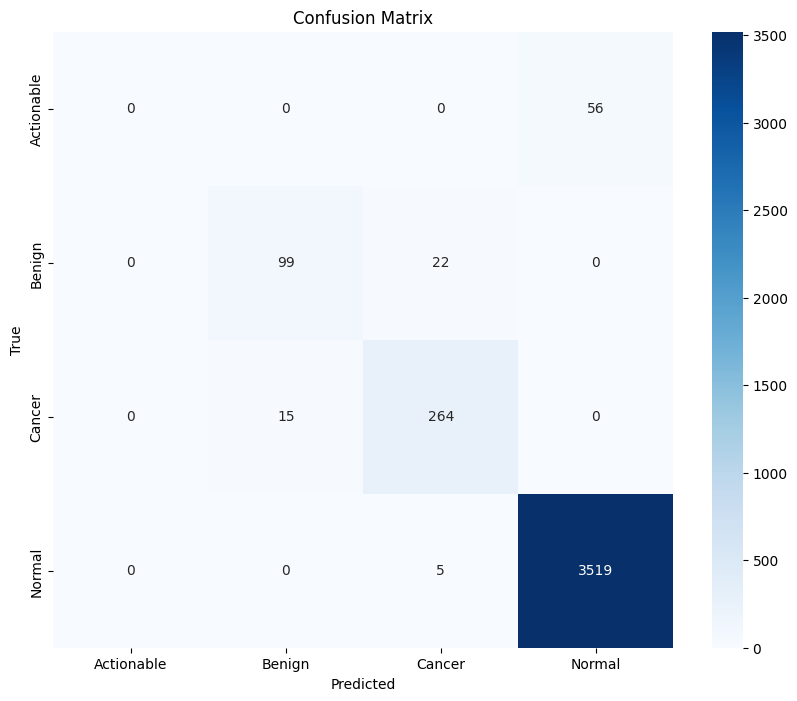

In [11]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Test Todas Normales'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [7]:
# Definir la ruta donde se encuentran los archivos .pkl
history_dir = 'Validación cruzada'
combined_history = {}

# Función para combinar los historiales
def combine_histories(histories):
    combined = {}
    for history in histories:
        for key, values in history.items():
            if key not in combined:
                combined[key] = []
            combined[key].extend(values)
    return combined

# Cargar los archivos .pkl
histories = []
for fold in range(1, 6):
    file_path = os.path.join(history_dir, f'model_fold_{fold}_50_epochs.pkl')
    with open(file_path, 'rb') as file:
        history = pickle.load(file)
        histories.append(history)

# Combinar los historiales
combined_history = combine_histories(histories)

# Guardar el historial combinado en un nuevo archivo .pkl
with open(os.path.join(history_dir, 'combined_history.pkl'), 'wb') as file:
    pickle.dump(combined_history, file)

print("Historiales combinados y guardados en 'Validación cruzada DA/combined_history.pkl'")

Historiales combinados y guardados en 'Validación cruzada DA/combined_history.pkl'


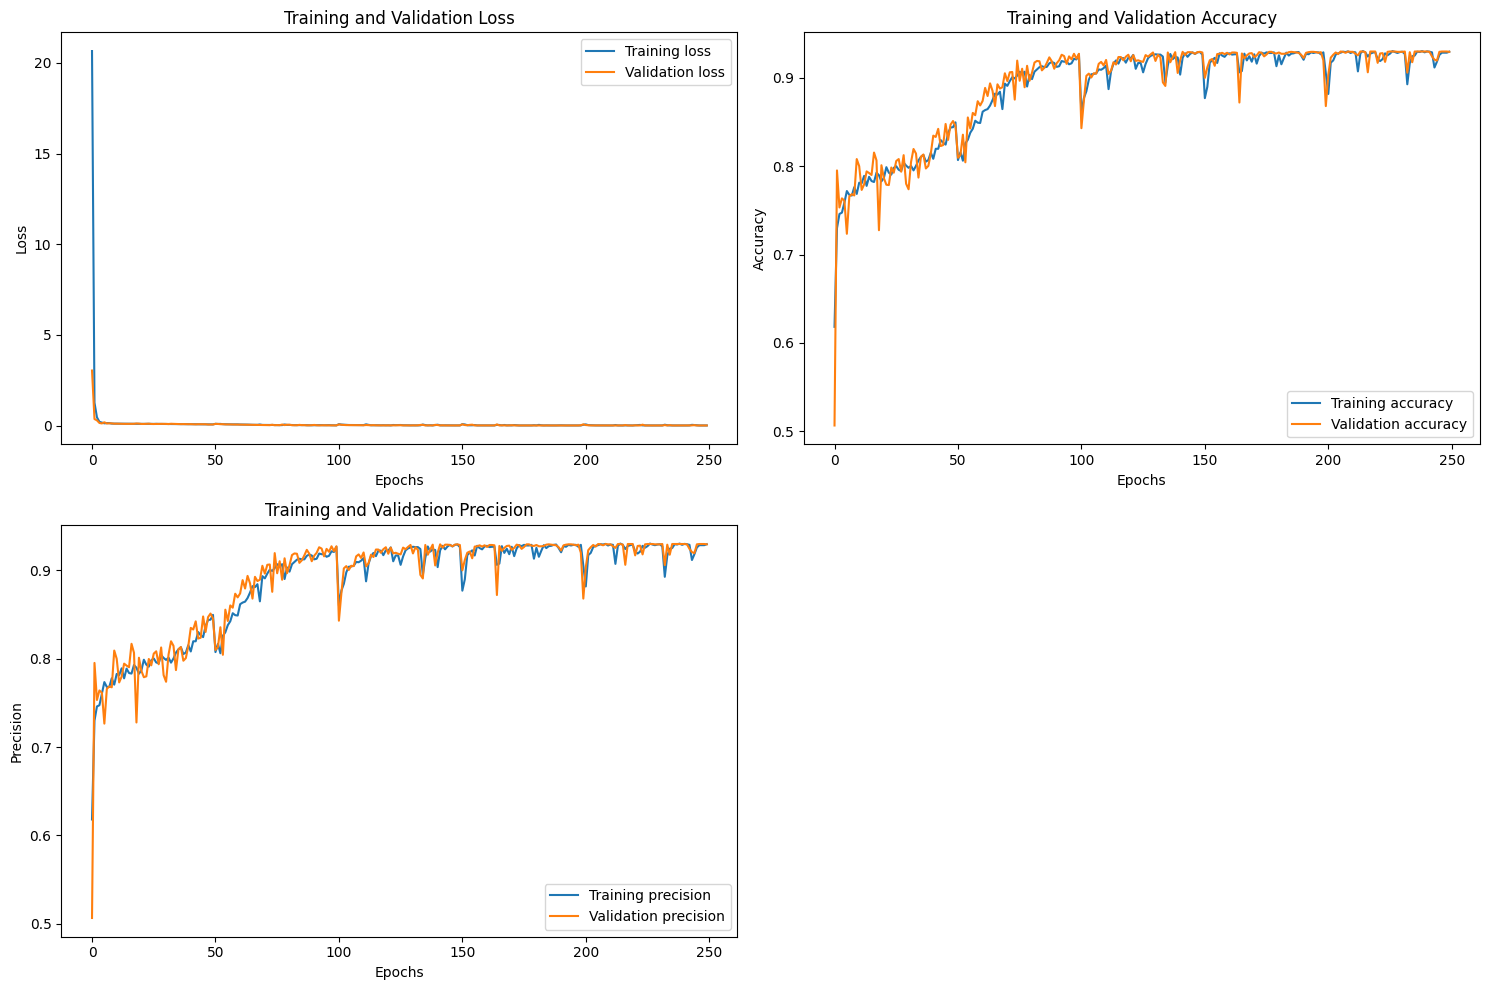

In [10]:
file_path = "Validación cruzada/combined_history.pkl"
with open(file_path, 'rb') as file:
        history = pickle.load(file)

plot_combined_history(history)

In [4]:
model_dir = 'Validación cruzada'
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Test'

test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)

for fold in range(1, 6):
    model_paths = [
        os.path.join(model_dir, f'model_fold_{fold}_50_epochs.keras'),
        os.path.join(model_dir, f'best_model{fold}.keras')
    ]
    for model_path in model_paths:
        print(f"Evaluando modelo {model_path}:")
        model.load_weights(model_path)

        test_metrics = model.evaluate(test_generator, steps=len(test_generator))
        print(f"Resultados del modelo {model_path}: {test_metrics}")

print("Evaluación completada.")

Evaluando modelo Validación cruzada\model_fold_1_50_epochs.keras:
85/85 [==============================] - 43s 212ms/step - loss: 0.1101 - accuracy: 0.8035 - precision: 0.8035
Resultados del modelo Validación cruzada\model_fold_1_50_epochs.keras: [0.11011938005685806, 0.8035294413566589, 0.8035294413566589]
Evaluando modelo Validación cruzada\best_model1.keras:
85/85 [==============================] - 18s 213ms/step - loss: 0.1036 - accuracy: 0.8059 - precision: 0.8068
Resultados del modelo Validación cruzada\best_model1.keras: [0.10363037139177322, 0.8058823347091675, 0.8068315386772156]
Evaluando modelo Validación cruzada\model_fold_2_50_epochs.keras:
85/85 [==============================] - 18s 214ms/step - loss: 0.1378 - accuracy: 0.8588 - precision: 0.8588
Resultados del modelo Validación cruzada\model_fold_2_50_epochs.keras: [0.1377859264612198, 0.8588235378265381, 0.8588235378265381]
Evaluando modelo Validación cruzada\best_model2.keras:
85/85 [==============================] - 

In [ ]:
model_dir = 'Validación cruzada'
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_299/Test'

# Suponiendo que MedicalImageDataGenerator y model están definidos en el entorno
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)

# Diccionarios para almacenar los resultados
loss_results = {}
accuracy_results = {}
precision_results = {}

for fold in range(1, 6):
    model_paths = [
        os.path.join(model_dir, f'model_fold_{fold}_50_epochs.keras'),
        os.path.join(model_dir, f'best_model{fold}.keras')
    ]
    for model_path in model_paths:
        print(f"Evaluando modelo {model_path}:")
        model.load_weights(model_path)

        test_metrics = model.evaluate(test_generator, steps=len(test_generator))
        print(f"Resultados del modelo {model_path}: {test_metrics}")
        
        # Suponiendo que test_metrics contiene [loss, accuracy, precision, ...]
        model_name = os.path.basename(model_path)
        loss_results[model_name] = test_metrics[0]
        accuracy_results[model_name] = test_metrics[1]
        precision_results[model_name] = test_metrics[2]

print("Evaluación completada.")

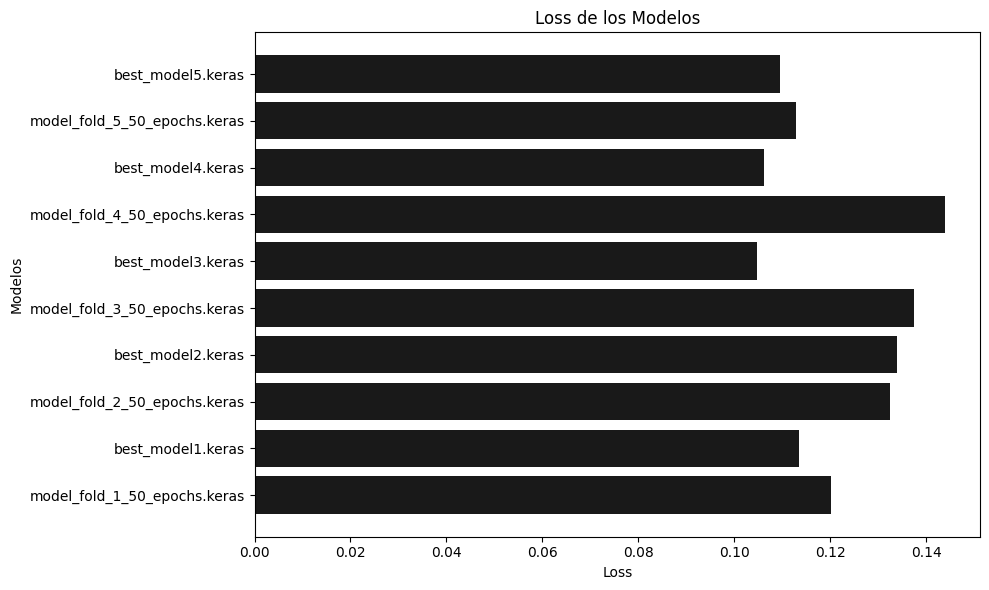

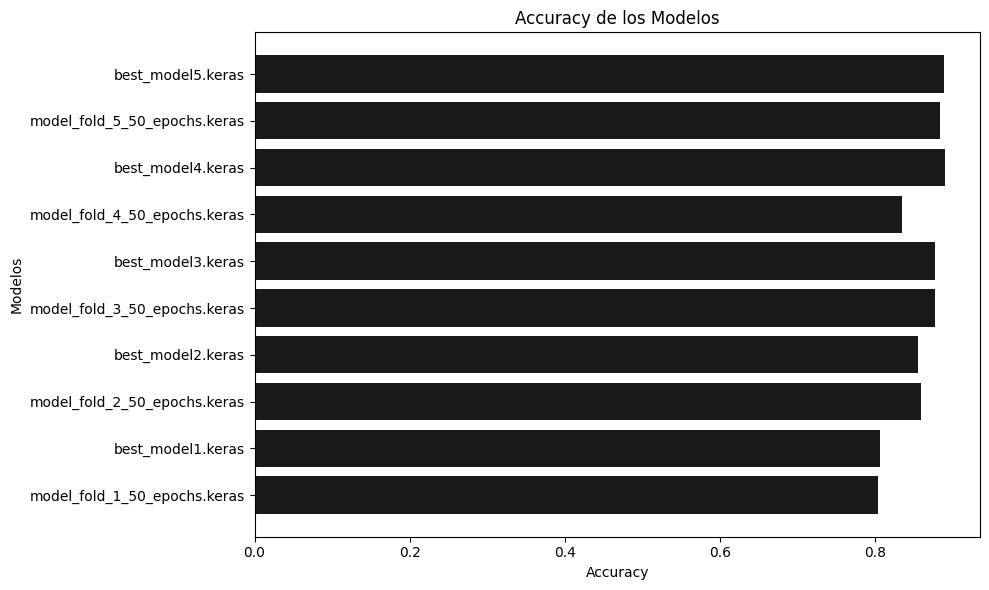

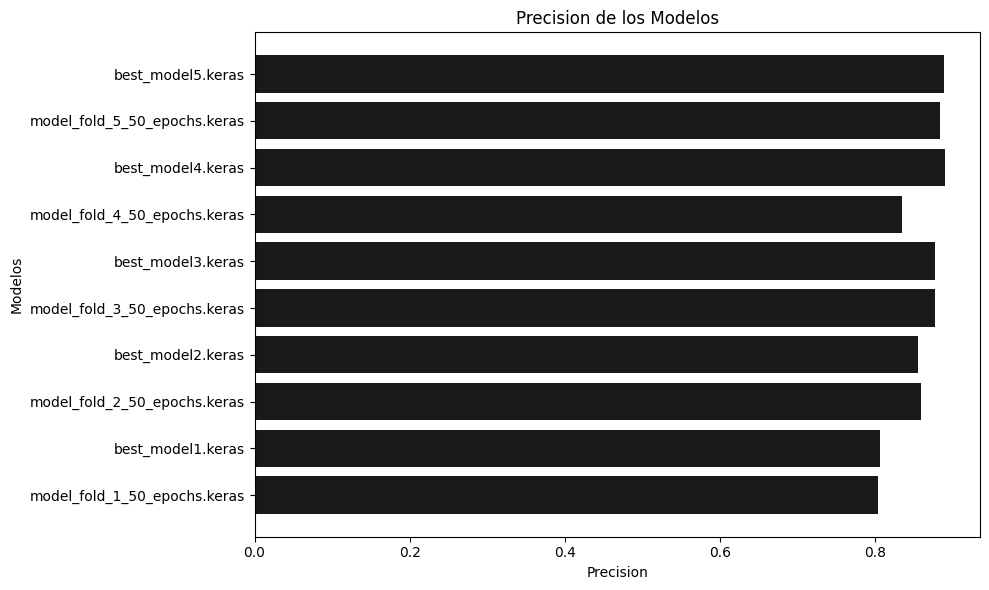

In [10]:
# Función para graficar los resultados
def plot_metrics(metric_dict, metric_name):
    names = list(metric_dict.keys())
    values = list(metric_dict.values())

    plt.figure(figsize=(10, 6))
    plt.barh(names, values, color='#191919')
    plt.ylabel('Modelos')
    plt.xlabel(metric_name)
    plt.title(f'{metric_name} de los Modelos')
    plt.tight_layout()
    plt.show()

# Graficar loss, accuracy y precision
plot_metrics(loss_results, 'Loss')
plot_metrics(accuracy_results, 'Accuracy')
plot_metrics(precision_results, 'Precision')

# Validacion cruzada DA

In [4]:
# Entrenar el modelo
for fold in range(1, 6):
    print(f"Training fold {fold}/5")
    train_data_dir = f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/Fold_{fold}/Training'
    val_data_dir =   f'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/Fold_{fold}/Validation'

    train_generator = MedicalImageDataGenerator(train_data_dir, indices=None, batch_size=10)
    val_generator = MedicalImageDataGenerator(train_data_dir, indices=None, batch_size=10, shuffle=False)


    checkpoint_filepath = f'Validacion cruzada DA/best_model{fold}.keras'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
    
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=50,
                        steps_per_epoch=len(train_generator),
                        validation_steps=len(val_generator),
                        callbacks=[model_checkpoint_callback])
    model.save(f"Validacion cruzada DA/model_fold_{fold}_50_epochs.keras")
    with open(f"Validacion cruzada DA/model_fold_{fold}_50_epochs.pkl", 'wb') as file:
        pickle.dump(history.history, file)

Training fold 1/5
Epoch 1/50
352/352 [==============================] - 216s 487ms/step - loss: 10.5216 - accuracy: 0.6875 - precision: 0.6877 - val_loss: 0.7457 - val_accuracy: 0.7957 - val_precision: 0.7957
Epoch 2/50
352/352 [==============================] - 147s 418ms/step - loss: 0.5292 - accuracy: 0.7645 - precision: 0.7647 - val_loss: 0.5525 - val_accuracy: 0.7000 - val_precision: 0.7000
Epoch 3/50
352/352 [==============================] - 158s 450ms/step - loss: 0.2601 - accuracy: 0.7744 - precision: 0.7750 - val_loss: 0.1343 - val_accuracy: 0.8244 - val_precision: 0.8243
Epoch 4/50
352/352 [==============================] - 148s 419ms/step - loss: 0.1396 - accuracy: 0.8009 - precision: 0.8007 - val_loss: 0.1264 - val_accuracy: 0.7804 - val_precision: 0.7810
Epoch 5/50
352/352 [==============================] - 147s 418ms/step - loss: 0.1164 - accuracy: 0.8043 - precision: 0.8051 - val_loss: 0.1221 - val_accuracy: 0.8131 - val_precision: 0.8146
Epoch 6/50
352/352 [===========

In [6]:
# Definir la ruta donde se encuentran los archivos .pkl
history_dir = 'Validacion cruzada DA'
combined_history = {}

# Función para combinar los historiales
def combine_histories(histories):
    combined = {}
    for history in histories:
        for key, values in history.items():
            if key not in combined:
                combined[key] = []
            combined[key].extend(values)
    return combined

# Cargar los archivos .pkl
histories = []
for fold in range(1, 6):
    file_path = os.path.join(history_dir, f'model_fold_{fold}_50_epochs.pkl')
    with open(file_path, 'rb') as file:
        history = pickle.load(file)
        histories.append(history)

# Combinar los historiales
combined_history = combine_histories(histories)

# Guardar el historial combinado en un nuevo archivo .pkl
with open(os.path.join(history_dir, 'combined_history.pkl'), 'wb') as file:
    pickle.dump(combined_history, file)

print("Historiales combinados y guardados en 'Validación cruzada DA/combined_history.pkl'")

Historiales combinados y guardados en 'Validación cruzada DA/combined_history.pkl'


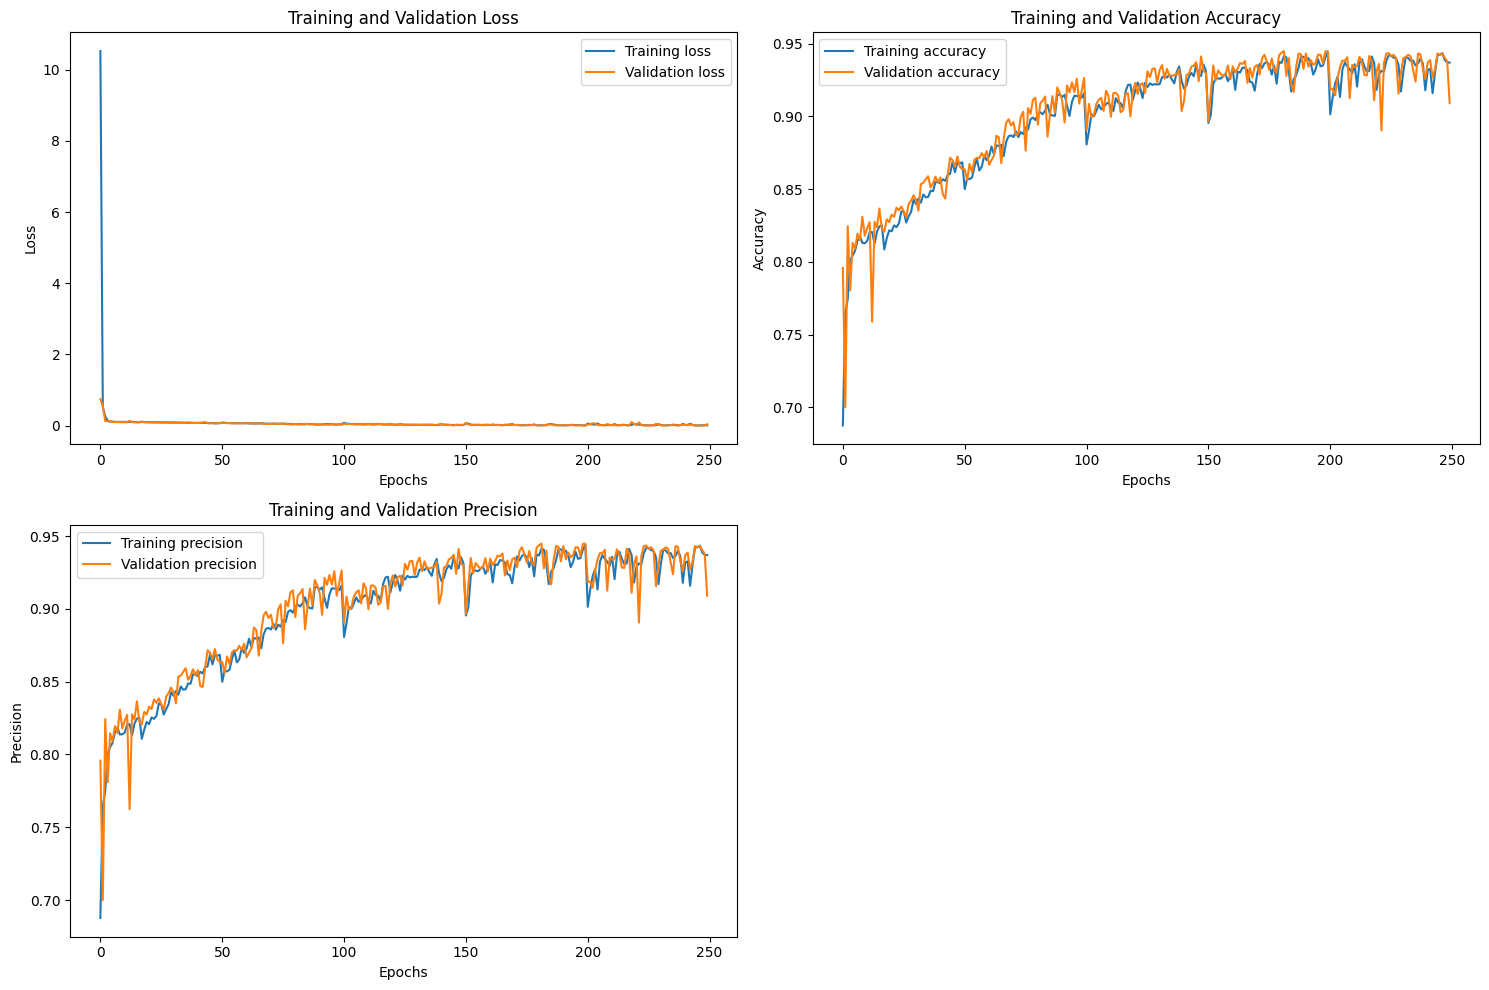

In [8]:
file_path = "Validacion cruzada DA/combined_history.pkl"
with open(file_path, 'rb') as file:
        history = pickle.load(file)

plot_combined_history(history)

In [13]:
model_dir = 'Validacion cruzada DA'
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/Test'

# Suponiendo que MedicalImageDataGenerator y model están definidos en el entorno
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)

# Diccionarios para almacenar los resultados
loss_results = {}
accuracy_results = {}
precision_results = {}

for fold in range(1, 6):
    model_paths = [
        os.path.join(model_dir, f'model_fold_{fold}_50_epochs.keras'),
        os.path.join(model_dir, f'best_model{fold}.keras')
    ]
    for model_path in model_paths:
        print(f"Evaluando modelo {model_path}:")
        model.load_weights(model_path)

        test_metrics = model.evaluate(test_generator, steps=len(test_generator))
        print(f"Resultados del modelo {model_path}: {test_metrics}")
        
        # Suponiendo que test_metrics contiene [loss, accuracy, precision, ...]
        model_name = os.path.basename(model_path)
        loss_results[model_name] = test_metrics[0]
        accuracy_results[model_name] = test_metrics[1]
        precision_results[model_name] = test_metrics[2]

print("Evaluación completada.")

Evaluando modelo Validacion cruzada DA\model_fold_1_50_epochs.keras:
109/109 [==============================] - 23s 213ms/step - loss: 0.1538 - accuracy: 0.8101 - precision: 0.8108
Resultados del modelo Validacion cruzada DA\model_fold_1_50_epochs.keras: [0.15380075573921204, 0.8100917339324951, 0.810835599899292]
Evaluando modelo Validacion cruzada DA\best_model1.keras:
109/109 [==============================] - 24s 213ms/step - loss: 0.1411 - accuracy: 0.8018 - precision: 0.8018
Resultados del modelo Validacion cruzada DA\best_model1.keras: [0.14113768935203552, 0.8018348813056946, 0.8018348813056946]
Evaluando modelo Validacion cruzada DA\model_fold_2_50_epochs.keras:
109/109 [==============================] - 24s 213ms/step - loss: 0.2566 - accuracy: 0.7872 - precision: 0.7872
Resultados del modelo Validacion cruzada DA\model_fold_2_50_epochs.keras: [0.2565929889678955, 0.7871559858322144, 0.7871559858322144]
Evaluando modelo Validacion cruzada DA\best_model2.keras:
109/109 [======

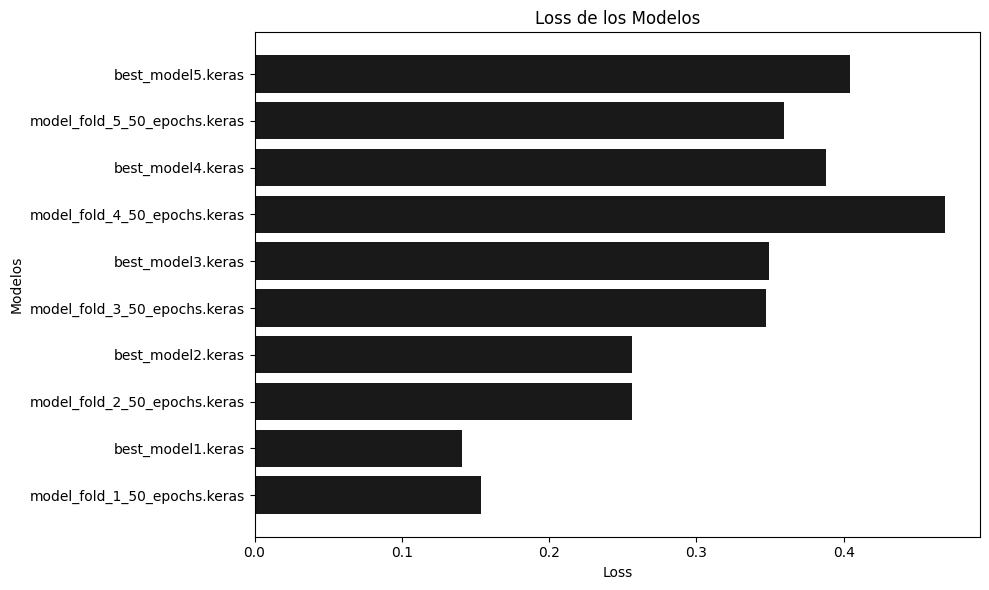

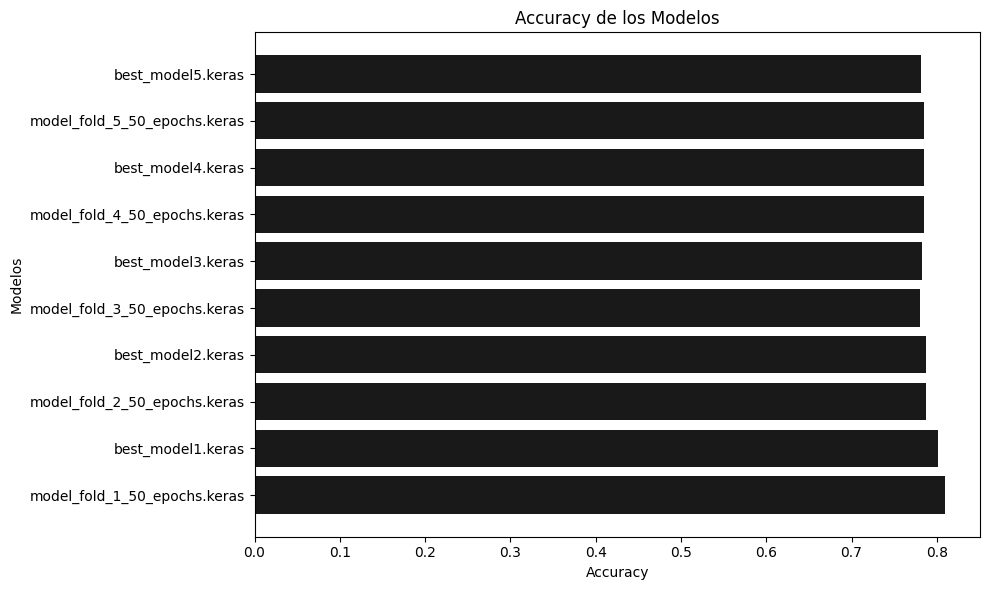

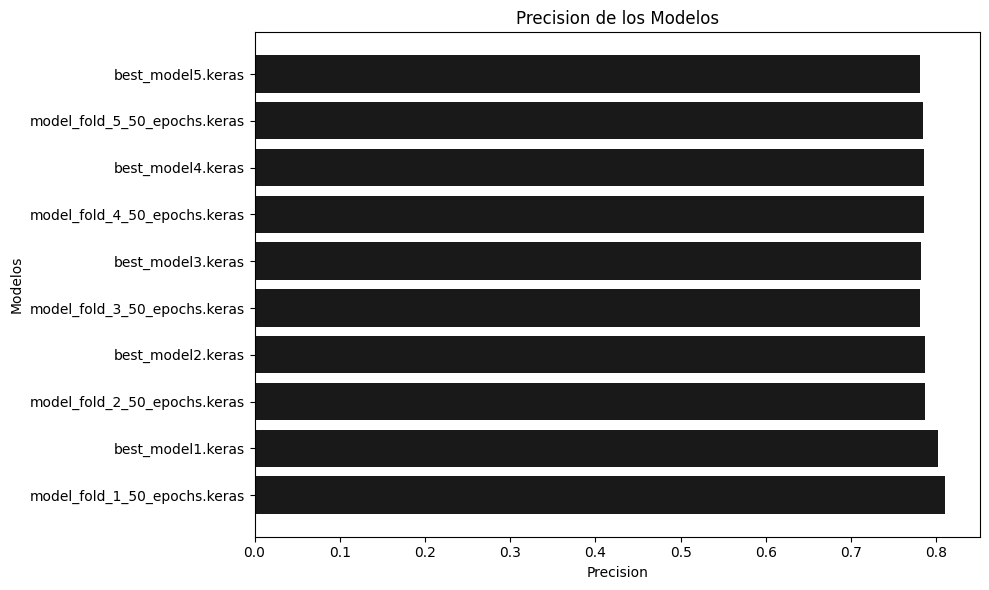

In [14]:
# Función para graficar los resultados
def plot_metrics(metric_dict, metric_name):
    names = list(metric_dict.keys())
    values = list(metric_dict.values())

    plt.figure(figsize=(10, 6))
    plt.barh(names, values, color='#191919')
    plt.ylabel('Modelos')
    plt.xlabel(metric_name)
    plt.title(f'{metric_name} de los Modelos')
    plt.tight_layout()
    plt.show()

# Graficar loss, accuracy y precision
plot_metrics(loss_results, 'Loss')
plot_metrics(accuracy_results, 'Accuracy')
plot_metrics(precision_results, 'Precision')

In [4]:
model.load_weights(os.path.join('Validación cruzada DA', 'best_model1.keras'))

Evaluación de los datos de Testeo:
109/109 [==============================] - 36s 200ms/step


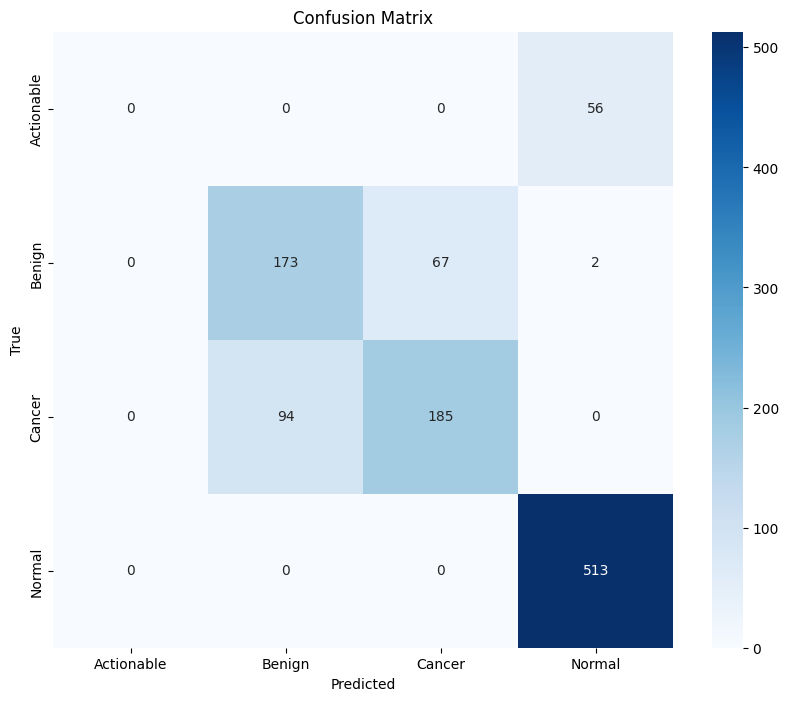

In [5]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/Test'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Evaluación de los datos de Testeo:
361/361 [==============================] - 73s 201ms/step


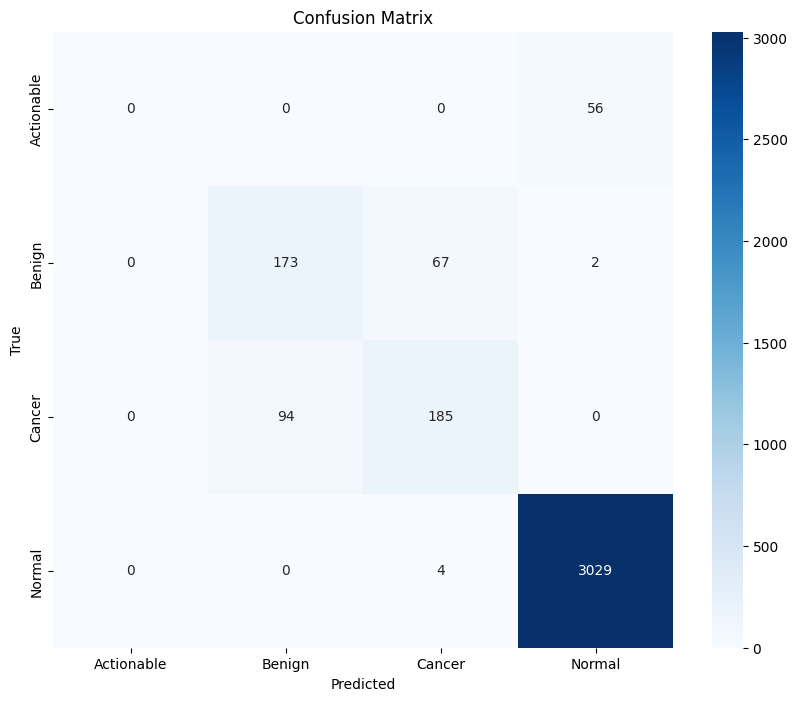

In [6]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/TestTodasNormales'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [7]:
model.load_weights(os.path.join('Validación cruzada DA', 'model_fold_1_50_epochs.keras'))

Evaluación de los datos de Testeo:
109/109 [==============================] - 22s 200ms/step


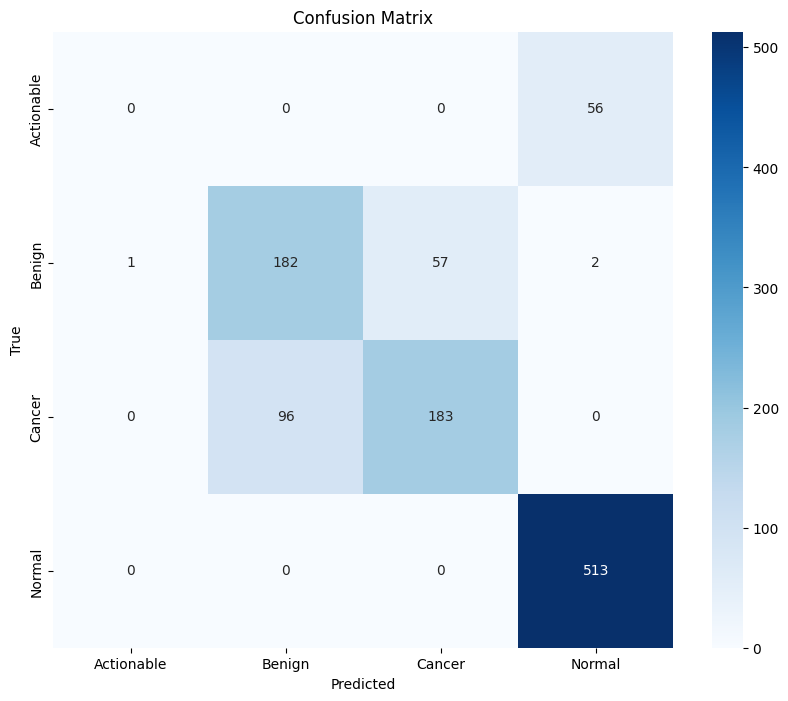

In [8]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/Test'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Evaluación de los datos de Testeo:
361/361 [==============================] - 72s 200ms/step


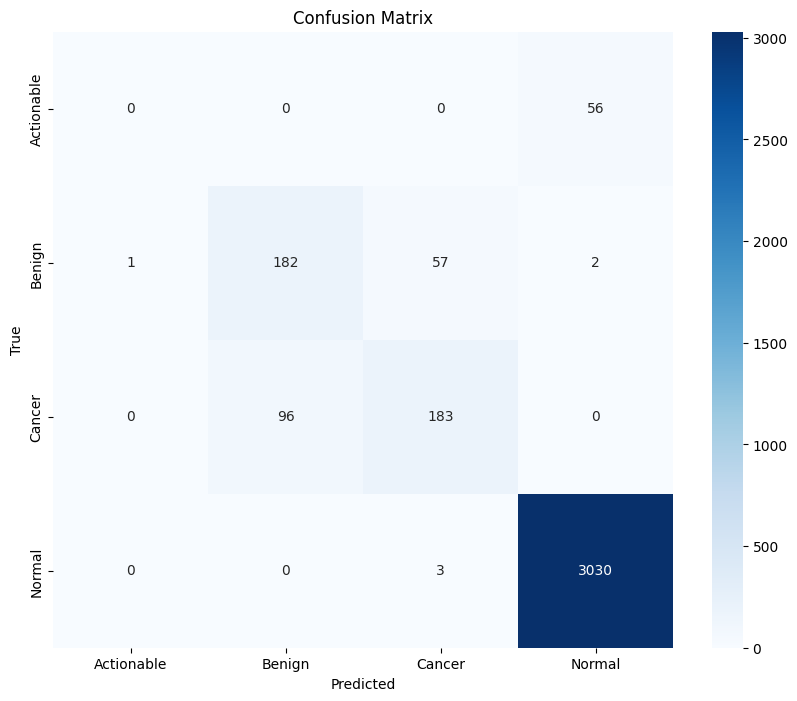

In [9]:
# Matriz de confusión
print("Evaluación de los datos de Testeo:")
test_data_dir = 'E:/Numpys/Array/TodasBenignMalignant/Validacion_Cruzada_DA_299/TestTodasNormales'
test_generator = MedicalImageDataGenerator(test_data_dir, indices=None, batch_size=10, shuffle=False)
test_metrics = model.evaluate(test_generator, steps=len(test_generator))


y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for _, labels in test_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Asegurarse de que y_true esté en formato categórico
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

labels = ['Actionable', 'Benign', 'Cancer', 'Normal']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()